# Model Training Notebook
## Training HFE-DDL Model and Baselines

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import pickle
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import plot_model

# Add src to path
sys.path.append('../src')
from data_preprocessing import DataPreprocessor
from hfe_ddl_model import HFE_DDL_Model
from baselines import BaselineModels

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Create outputs directory
# os.makedirs('../outputs', exist_ok=True)

## 1. Load Preprocessed Data

In [2]:
# Load preprocessed data
print("Loading preprocessed data...")
with open('../data/preprocessed_data.pkl', 'rb') as f:
    preprocessed_data = pickle.load(f)

X_tfidf = preprocessed_data['X_tfidf']
X_sequences = preprocessed_data['X_sequences']
y = preprocessed_data['y']

print("Data shapes:")
print(f"TF-IDF features: {X_tfidf.shape}")
print(f"Sequences: {X_sequences.shape}")
print(f"Labels: {y.shape}")

# Load balanced dataframe for baselines
balanced_df = pd.read_csv('../data/LVDAndro_APKs_downsampled.csv', low_memory=False)
print(f"\nBalanced dataset shape: {balanced_df.shape}")
print(f"Class distribution: {balanced_df['Vulnerability_status'].value_counts().to_dict()}")

Loading preprocessed data...
Data shapes:
TF-IDF features: (383895, 1000)
Sequences: (383895, 15)
Labels: (383895,)

Balanced dataset shape: (383898, 20)
Class distribution: {0: 191949, 1: 191949}


## 2. HFE-DDL Model Training

In [3]:
# Initialize HFE-DDL model
print("Initializing HFE-DDL Model...")
hfe_ddl = HFE_DDL_Model(random_state=42)

# Build model
model = hfe_ddl.build_model(X_tfidf.shape[1], X_sequences.shape[1])

# Display model architecture
print("\nModel Architecture:")
model.summary()

# Plot model architecture
try:
    plot_model(model, to_file='../outputs/hfe_ddl_architecture.png', 
               show_shapes=True, show_layer_names=True)
    print("\nModel architecture saved to '../outputs/hfe_ddl_architecture.png'")
except:
    print("\nNote: graphviz required for model plotting. Install with: pip install graphviz")

Initializing HFE-DDL Model...

Model Architecture:
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 15)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 15, 100)      1000000     ['input_2[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 15, 100)      0           ['embedding[0][0]']              
                                                                                                  
 input_1 (InputLayer)           [(None, 1000)]       0           []                               
                                           

In [ ]:
# Cross-validation for HFE-DDL
print("Running HFE-DDL Cross-Validation...")

n_runs = 1
n_folds = 10
seeds = [42, 123, 456, 789, 999][:n_runs]

hfe_ddl_results = []

for run_idx, seed in enumerate(seeds):
    print(f"\nRun {run_idx+1}/{n_runs} (Seed: {seed})")
    
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X_tfidf, y)):
        print(f"  Training Fold {fold+1}/{n_folds}...", end=" ")
        
        # Split data
        X_train_tfidf, X_test_tfidf = X_tfidf[train_idx], X_tfidf[test_idx]
        X_train_seq, X_test_seq = X_sequences[train_idx], X_sequences[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Initialize new model for each fold
        fold_model = HFE_DDL_Model(random_state=seed)
        model = fold_model.build_model(X_tfidf.shape[1], X_sequences.shape[1])
        
        # Train model
        history = fold_model.train(
            X_train_tfidf, X_train_seq, y_train,
            validation_data=(X_test_tfidf, X_test_seq, y_test),
            epochs=15,
            batch_size=32
        )
        
        # Predict and evaluate
        y_pred, y_pred_proba = fold_model.predict(X_test_tfidf, X_test_seq)
        
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
        
        f1 = f1_score(y_test, y_pred, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=1)
        recall = recall_score(y_test, y_pred, zero_division=1)
        
        conf_matrix = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = conf_matrix.ravel()
        
        result = {
            'run': run_idx + 1,
            'fold': fold + 1,
            'seed': seed,
            'model': 'hfe_ddl',
            'f1_score': f1,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'tn': tn,
            'fp': fp,
            'fn': fn,
            'tp': tp
        }
        
        hfe_ddl_results.append(result)
        print(f"F1: {f1:.4f}, Acc: {accuracy:.4f}")

# Save HFE-DDL results
hfe_ddl_df = pd.DataFrame(hfe_ddl_results)
hfe_ddl_df.to_csv('../outputs/hfe_ddl_results.csv', index=False)
print(f"\nHFE-DDL results saved to '../outputs/hfe_ddl_results.csv'")

# Display average performance
avg_performance = hfe_ddl_df[['f1_score', 'accuracy', 'precision', 'recall']].mean()
print("\nAverage HFE-DDL Performance:")
for metric, value in avg_performance.items():
    print(f"  {metric}: {value:.4f}")

## 3. Word2Vec Baseline

In [ ]:
# Initialize baseline models
baselines = BaselineModels(random_state=42)

# Run Word2Vec baseline
print("Training Word2Vec Baseline...")
word2vec_results = baselines.run_word2vec_baseline(balanced_df, n_runs=1, n_folds=10)

print("\nWord2Vec Baseline Completed!")
print(f"Results saved to '../outputs/word2vec_results2.csv'")

# Display average performance
avg_word2vec = word2vec_results[['f1_score', 'accuracy', 'precision', 'recall']].mean()
print("\nAverage Word2Vec Performance:")
for metric, value in avg_word2vec.items():
    print(f"  {metric}: {value:.4f}")

## 4. Code2Vec Baseline

In [ ]:
# Run Code2Vec baseline
print("Training Code2Vec Baseline...")
code2vec_results = baselines.run_code2vec_baseline(balanced_df, n_runs=1, n_folds=10)

print("\nCode2Vec Baseline Completed!")
print(f"Results saved to '../outputs/code2vec_results.csv'")

# Display average performance
avg_code2vec = code2vec_results[['f1_score', 'accuracy', 'precision', 'recall']].mean()
print("\nAverage Code2Vec Performance:")
for metric, value in avg_code2vec.items():
    print(f"  {metric}: {value:.4f}")

## 5. CodeBERT Baseline (Optional)

In [ ]:
# Note: CodeBERT requires transformers and torch
# Uncomment the following lines if you have these dependencies installed

# print("Training CodeBERT Baseline...")
# codebert_results = baselines.run_codebert_baseline(balanced_df, n_runs=1, n_folds=10)
# print("\nCodeBERT Baseline Completed!")
# print(f"Results saved to '../outputs/codebert_results.csv'")

# For now, we'll create a placeholder if CodeBERT is not available
print("CodeBERT Baseline:")
print("Note: CodeBERT requires transformers and torch libraries.")
print("To run CodeBERT baseline, install: pip install transformers torch")
print("Then uncomment the code in this section.")

## 6. Training Summary

Training Summary:
           f1_score         accuracy         precision          recall        
               mean     std     mean     std      mean     std    mean     std
model_name                                                                    
Code2Vec     0.9507  0.0012   0.9515  0.0012    0.9670  0.0010  0.9349  0.0019
HFE-DDL      0.9606  0.0008   0.9608  0.0009    0.9647  0.0027  0.9567  0.0029
Word2Vec     0.9469  0.0014   0.9477  0.0014    0.9612  0.0017  0.9330  0.0020
codebert     0.9340  0.0014   0.9357  0.0013    0.9595  0.0010  0.9098  0.0022


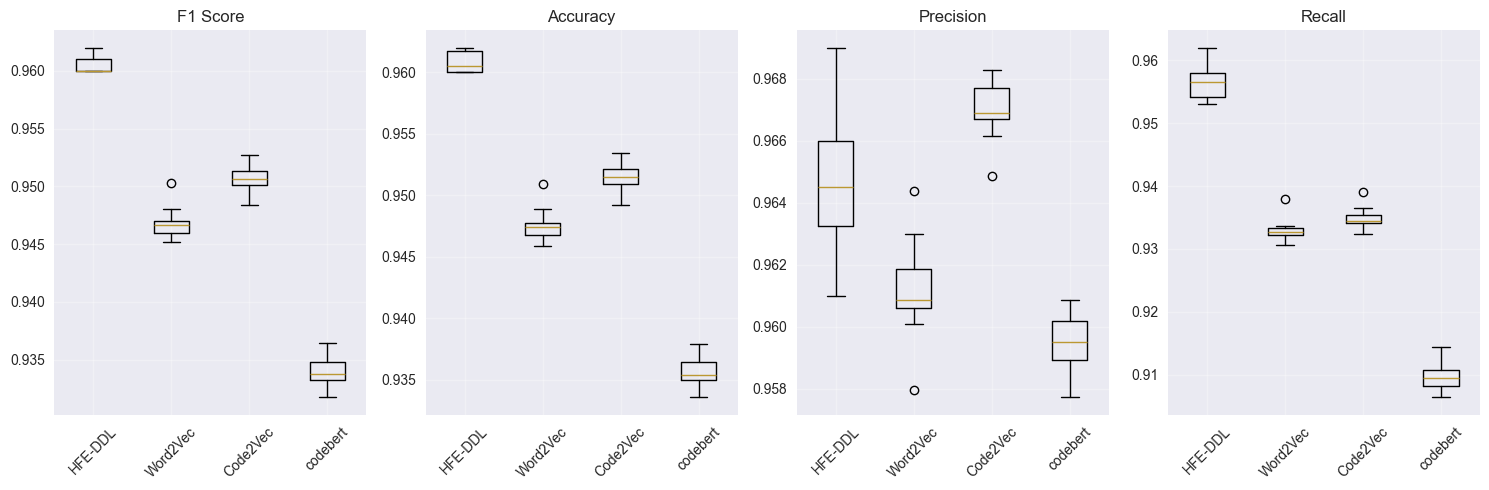


Performance comparison plot saved to '../outputs/training_performance_comparison.png'

Model training completed successfully!

Next step: Run 03_results_analysis.ipynb for detailed statistical analysis


In [5]:
# Load all results for comparison
results_files = {
    'HFE-DDL': '../outputs/hfe_ddl_results.csv',
    'Word2Vec': '../outputs/word2vec_results.csv',
    'Code2Vec': '../outputs/code2vec_results.csv',
    'codebert': '../outputs/codebert_results.csv'
}

all_results = []
for model_name, file_path in results_files.items():
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        df['model_name'] = model_name
        all_results.append(df)

if all_results:
    combined_results = pd.concat(all_results, ignore_index=True)
    
    # Calculate average performance by model
    summary = combined_results.groupby('model_name').agg({
        'f1_score': ['mean', 'std'],
        'accuracy': ['mean', 'std'],
        'precision': ['mean', 'std'],
        'recall': ['mean', 'std']
    }).round(4)
    
    print("Training Summary:")
    print("=" * 60)
    print(summary)
    
    # Visualize performance comparison
    plt.figure(figsize=(15, 5))
    
    metrics = ['f1_score', 'accuracy', 'precision', 'recall']
    for i, metric in enumerate(metrics, 1):
        plt.subplot(1, 4, i)
        
        metric_data = []
        model_names = []
        for model_name in combined_results['model_name'].unique():
            model_data = combined_results[combined_results['model_name'] == model_name][metric]
            metric_data.append(model_data)
            model_names.append(model_name)
        
        plt.boxplot(metric_data, labels=model_names)
        plt.title(f'{metric.replace("_", " ").title()}')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../outputs/training_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"\nPerformance comparison plot saved to '../outputs/training_performance_comparison.png'")

print("\nModel training completed successfully!")
print("\nNext step: Run 03_results_analysis.ipynb for detailed statistical analysis")